### Modeling calcium data in the frequency domain
---

The magnitude (or absolute value) of the FFT output represents the amplitude of the various frequency components present in the original time-domain signal. It basically tells us "how much" of a certain frequency is present in the signal. For instance, if you have a sine wave with a frequency of 5 Hz and an amplitude of 10 units, then the magnitude of the FFT at 5 Hz will be proportional to 10. 

In most practical applications, we're often interested in the square of the magnitude of the FFT, because it represents the power of the signal at each frequency, also known as the power spectral density (PSD). Thus, the PSD is simply the magnitude squared of the Fourier transform and it gives the distribution of power over frequency. 

*Last updated: 11 July 2023*

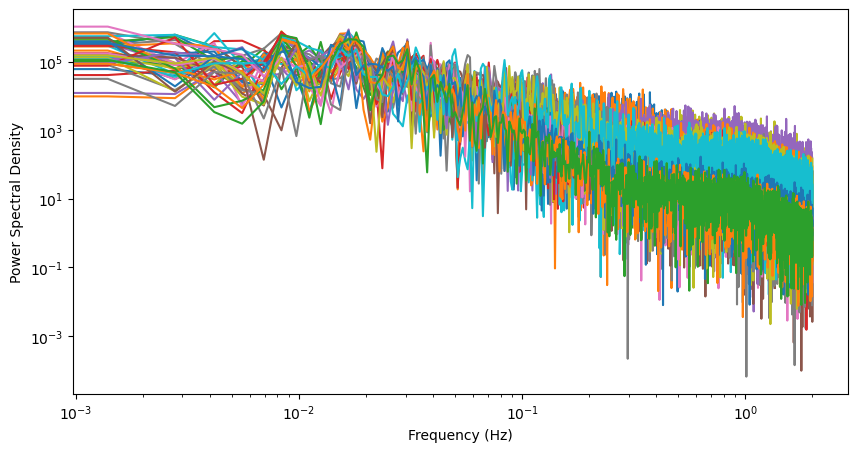

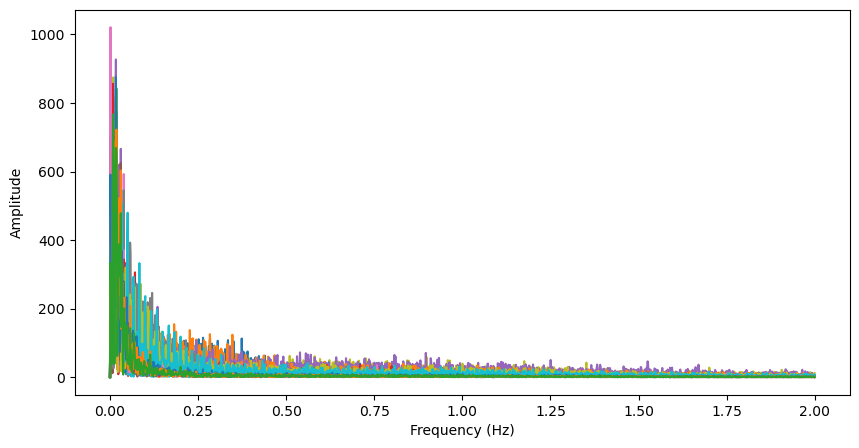

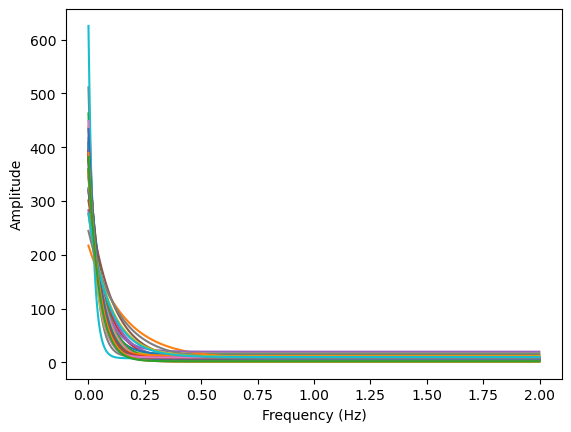

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from data._utils import pick_worm, load_dataset

Kato2015 = load_dataset("Kato2015")
single_worm_dataset = pick_worm(Kato2015, "worm0")

calcium = single_worm_dataset["calcium_data"]
mask = single_worm_dataset["named_neurons_mask"]
dt = single_worm_dataset["resample_median_dt"]

data = calcium[:, mask]

fft_data = torch.fft.rfft(data, dim=0)
fft_freqs = torch.fft.rfftfreq(data.size(0), d=dt)

# Compute the amplitude of the FFT
amp = torch.abs(fft_data)

# Compute the power spectral density
psd = amp**2

# Plot the power spectral density
plt.figure(figsize=(10, 5))
plt.loglog(fft_freqs, psd)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.show()

# Plot the magnitude of the FFT
plt.figure(figsize=(10, 5))
plt.plot(fft_freqs, amp)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()


# Define the function to fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c


calcium = single_worm_dataset["calcium_data"]
mask = single_worm_dataset["named_neurons_mask"]
dt = single_worm_dataset["resample_median_dt"]

data = calcium[:, mask]

fft_data = torch.fft.rfft(data, dim=0)
fft_freqs = torch.fft.rfftfreq(data.size(0), d=dt)

# Convert fft_data and fft_freqs to numpy for use with curve_fit
fft_data_np = fft_data.detach().numpy()
fft_freqs_np = fft_freqs.detach().numpy()

# Fit function to each column of data
num_neurons = fft_data_np.shape[1]
fit_params = np.zeros((num_neurons, 3))  # for a, b, and c
for i in range(num_neurons):
    popt, pcov = curve_fit(func, fft_freqs_np, np.abs(fft_data_np[:, i]))
    fit_params[i, :] = popt

# Generate x values
x = np.linspace(fft_freqs_np.min(), fft_freqs_np.max(), num=1000)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each fitted curve
for i in range(num_neurons):
    # Generate y values for this curve
    y = func(x, *fit_params[i])
    # Plot the curve
    ax.plot(x, y)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()